In [1]:
#check GPU status
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed May  6 19:44:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import models, layers
%matplotlib inline

In [0]:
#simple monomial function
def calculate(x):
  return x*x*x

In [5]:
inputs = [round(x,1) for x in np.arange(-0.5,0.6,0.1)]
print(inputs)

[-0.5, -0.4, -0.3, -0.2, -0.1, -0.0, 0.1, 0.2, 0.3, 0.4, 0.5]


In [6]:
outputs = [calculate(x) for x in inputs]
print(outputs)

[-0.125, -0.06400000000000002, -0.027, -0.008000000000000002, -0.0010000000000000002, -0.0, 0.0010000000000000002, 0.008000000000000002, 0.027, 0.06400000000000002, 0.125]


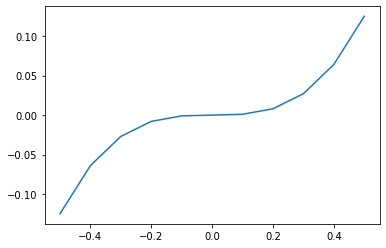

In [7]:
plt.plot(inputs, outputs)

In [0]:
#example generation of samples
def generate_sample(n=100):
  x = np.random.rand(n) - 0.5
  y = calculate(x)
  x = x.reshape((n,1))
  y = y.reshape((n,1))
  return np.hstack((x,y))

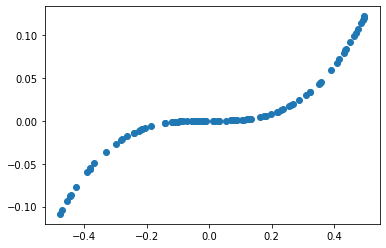

In [9]:
data = generate_sample()
plt.scatter(data[:,0], data[:,1])

In [0]:
#define the discriminator
def define_discriminator(n_inputs=2):
  model = tf.keras.Sequential()
  model.add(layers.Dense(25, activation='relu', kernel_initializer='he_uniform', 
                         input_dim=n_inputs))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [13]:
model = define_discriminator()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                75        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


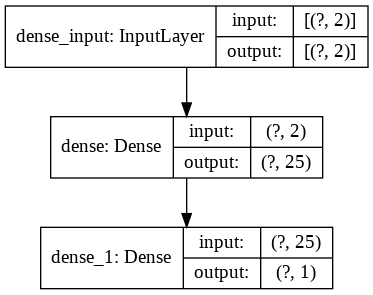

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def generate_real_samples(n=100):
  x1 = np.random.rand(n) - 0.5
  x2 = calculate(x1)
  x1 = x1.reshape((n,1))
  x2 = x2.reshape((n,1))
  X = np.hstack((x1,x2))
  y = np.ones((n,1))
  return X, y

In [0]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    X_real, y_real = generate_real_samples(half_batch)
    model.train_on_batch(X_real, y_real)
    X_fake, y_fake = generate_fake_samples(half_batch)
    model.train_on_batch(X_fake, y_fake)
    _, acc_real = model.evaluate(X_real, y_real, verbose=0)
    _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
    print(i, acc_real, acc_fake)

In [0]:
def define_generator(latent_dims=5, n_outputs=2):
  model = tf.keras.Sequential()
  model.add(layers.Dense(15, activation='relu', kernel_initializer='he_uniform',
                         input_dim=latent_dims))
  model.add(layers.Dense(n_outputs, activation='linear'))
  return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


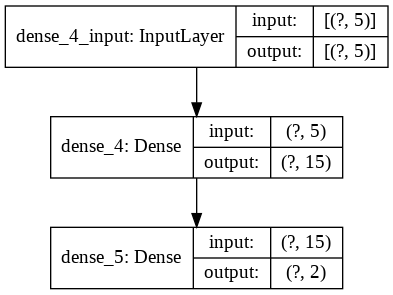

In [20]:
model = define_generator(5)
model.summary()
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def generate_latent_points(latent_dims, n):
  x = np.random.randn(latent_dims*n)
  x = x.reshape((n, latent_dims))
  return x

In [0]:
def generate_fake_samples(generator, latent_dim, n):
  x_input = generate_latent_points(latent_dim, n)
  X = generator.predict(x_input)
  y = np.zeros((n, 1))
  return X, y

In [0]:
def define_gan(generator, discriminator):
  discriminator.trainable = False
  model = tf.keras.Sequential()
  model.add(generator)
  model.add(discriminator)
  model.compile(loss='binary_crossentropy' ,optimizer='adam')
  return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 2)                 122       
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


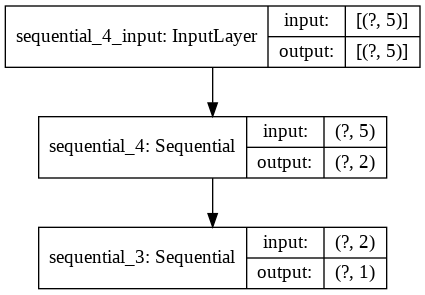

In [24]:
latent_dim = 5
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
  x_real, y_real = generate_real_samples(n)
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)

  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  
  print(epoch, acc_real, acc_fake)

  plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
  plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')

  filename = '/content/generated_plot_e%03d.png' % (epoch+1) 
  plt.savefig(filename)
  plt.close()

In [0]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):

  half_batch = int(n_batch/2)

  for i in range(n_epochs):
    x_real, y_real = generate_real_samples(half_batch)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    
    d_model.train_on_batch(x_real, y_real)
    d_model.train_on_batch(x_fake, y_fake)

    x_gan = generate_latent_points(latent_dim, n_batch)
    y_gan = np.ones((n_batch,1))

    gan_model.train_on_batch(x_gan, y_gan)

    if (i+1) % n_eval == 0:
      summarize_performance(i, g_model, d_model, latent_dim)


In [27]:
latent_dim = 5
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
train(generator, discriminator, gan_model, latent_dim, n_eval=200)

199 0.6299999952316284 0.800000011920929
399 0.5299999713897705 0.6600000262260437
599 0.7200000286102295 0.20000000298023224
799 0.9900000095367432 0.27000001072883606
999 1.0 0.1899999976158142
1199 0.75 0.28999999165534973
1399 0.6700000166893005 0.47999998927116394
1599 0.6100000143051147 0.47999998927116394
1799 0.44999998807907104 0.6700000166893005
1999 0.5 0.5899999737739563
2199 0.550000011920929 0.41999998688697815
2399 0.4099999964237213 0.5299999713897705
2599 0.28999999165534973 0.6299999952316284
2799 0.4399999976158142 0.5699999928474426
2999 0.5799999833106995 0.5199999809265137
3199 0.5299999713897705 0.5899999737739563
3399 0.4399999976158142 0.6800000071525574
3599 0.4000000059604645 0.9900000095367432
3799 0.47999998927116394 0.05000000074505806
3999 0.3400000035762787 0.2199999988079071
4199 0.3799999952316284 0.9800000190734863
4399 0.5199999809265137 0.3799999952316284
4599 0.6100000143051147 0.4300000071525574
4799 0.07999999821186066 0.9900000095367432
4999 0.9